# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
from joblib import dump, load
from sklearn_pandas import DataFrameMapper
from sklearn.metrics import f1_score,recall_score,precision_score

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect(r'/home/pranay/ML datasource/amazon-fine-food-reviews/database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries

final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

was way to hot for my blood, took a bite and did a jig  lol


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

was way to hot for my blood took a bite and did a jig lol


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
#filtered out whole reviews

from bs4 import BeautifulSoup
# Combining all the above stundents 
from tqdm import tqdm
# tqdm is for printing the status bar
word_counter = []
def filterised_text(text):
    preprocessed_text = []
    for sentance in tqdm(text):
        sentance = re.sub(r"http\S+", "", sentance)
        sentance = BeautifulSoup(sentance, 'lxml').get_text()
        sentance = decontracted(sentance)
        sentance = re.sub("\S*\d\S*", "", sentance).strip()
        sentance = re.sub('[^A-Za-z]+', ' ', sentance)
        # https://gist.github.com/sebleier/554280
        sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
        count = len(sentance.split())
        word_counter.append(count)
        preprocessed_text.append(sentance.strip())
    return preprocessed_text

In [23]:
preprocessed_reviews = filterised_text(final['Text'].values)
final['preprocessed_reviews']  = preprocessed_reviews
preprocessed_reviews[1822]

100%|██████████| 87773/87773 [00:27<00:00, 3187.13it/s]


'taste great using air popper not great little seeds fall popping'

In [24]:
final['numbers_of_words']  = word_counter
word_counter[1822]

11

## Preprocessing Review Summary

In [25]:
preprocessed_summary = filterised_text(final['Summary'].values)
final['preprocessed_summary']  = preprocessed_summary
preprocessed_summary[1822]

100%|██████████| 87773/87773 [00:17<00:00, 5149.20it/s]


'pop corn'

In [26]:
from sklearn.linear_model import LogisticRegression
# importing Cross validation libs
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import model_selection

# Python script for confusion matrix creation. 
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
# roc curve and auc
from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV

import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

In [27]:
avg_w2v_trained_model_100000 = '/home/pranay/ML trained models/W2V/avg_w2v_trained_model_100000'
avg_w2v_test_model_100000 = '/home/pranay/ML trained models/W2V/avg_w2v_test_model_100000'

w2v_tf_idf_trained_model_100000 = '/home/pranay/ML trained models/W2V_TFIDF/w2v_tf_idf_trained_model_100000'
w2v_tf_idf_test_model_100000 = '/home/pranay/ML trained models/W2V_TFIDF/w2v_tf_idf_test_model_100000'

In [28]:
# Common Methods

lambda_values = (1e-4, 1e-3,1e-2,0.05,1e-1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1e0,3,5,7,9,1e1,1e2,1e3)


def finding_best_lambda(X_tr,y_tr):
    # instantiate a Logistic Regression model
    lr = LogisticRegression(class_weight='balanced',n_jobs=-1, penalty='l2', random_state=1)

    param_grid=dict(C=lambda_values)
    
    #For time based splitting
    tscv = TimeSeriesSplit(n_splits=10)

    # instantiate the training grid search model
    train_grid = GridSearchCV(lr, param_grid, cv=tscv, scoring='roc_auc',n_jobs =-1,verbose=10 )
    
    # fit the training data to train model
    train_grid.fit(X_tr, y_tr)

    return train_grid


# plot a graph which show difference between validation error and training error
def plotAccuracyGraph(training_grid):
    alpha_range = [i for i in lambda_values]
    accuracy = [i for i in training_grid.cv_results_['mean_train_score']]
    accuracy_test = [i for i in training_grid.cv_results_['mean_test_score']]
    plt.semilogx(alpha_range, accuracy,'r',label='train_accuracy')
    plt.semilogx(alpha_range, accuracy_test,'b',label='validation_accuracy')
    plt.title('Accuracy plot')
    plt.xlabel('Alpha') 
    plt.ylabel('Accuracy')
    plt.grid('on')
    plt.legend()
    plt.show()


    
def train_with_optimal_lambda(optimal_lambda, penalty):
    if penalty == 'l1':
        lr = LogisticRegression(C=optimal_lambda,class_weight='balanced',n_jobs=2, penalty='l1',random_state=1)
        return lr
    else : 
        lr = LogisticRegression(C=optimal_lambda,class_weight='balanced',n_jobs=2, penalty='l2',random_state=1)
        return lr

# https://www.geeksforgeeks.org/confusion-matrix-machine-learning/    
def plotConfusionMatrix(y_test,pred):
    # calculate confusion matrix
    cm =  confusion_matrix(y_test,pred)
    class_label = ['negative', 'positive']
    df_conf_matrix = pd.DataFrame(cm, index=class_label, columns=class_label)
    # heatmap --> Plot rectangular data as a color-encoded matrix. 
    sns.heatmap(df_conf_matrix, annot=True, fmt='d')
    # give title to graph
    plt.title("Confusion Matrix")
    # mention axis label
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    # show the plot
    plt.show()
    

# https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
# plot AUC curve
def plotAUC_ROC(nb_optimal,X_train, y_train, X_test, y_test):
    # predict probabilities
    test_probs = nb_optimal.predict_proba(X_test)
    train_probs = nb_optimal.predict_proba(X_train)
    
    # keep probabilities for the positive outcome only
    test_probs = test_probs[:, 1]
    train_probs = train_probs[:, 1]
    
    # calculate AUC
    test_auc = roc_auc_score(y_test, test_probs)
    train_auc = roc_auc_score(y_train, train_probs)
    
    # calculate roc curve
    train_fpr, train_tpr, thresholds = roc_curve(y_train, train_probs)
    test_fpr, test_tpr, thresholds2 = roc_curve(y_test, test_probs)
    
    # plot no skill
    pyplot.plot([0, 1], [0, 1], linestyle='--')
    
    # plot the roc curve for the model
    pyplot.plot(train_fpr, train_tpr, 'r',marker='.', label="train AUC ="+str(train_auc))
    pyplot.plot(test_fpr, test_tpr, 'b',marker='.',label="test AUC ="+str(test_auc))
    
    pyplot.legend()
    pyplot.xlabel("K: hyperparameter")
    pyplot.ylabel("AUC")
    pyplot.title("ERROR PLOTS")
    # show the plot
    pyplot.show()
    
    return train_auc, test_auc

class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'
    
# https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers

def show_most_informative_features(feature_names, clf, n=10):
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top_1 = coefs_with_fns[:n]
    top_2 = coefs_with_fns[:-(n + 1):-1]
    print(color.BOLD+"Important words in negative reviews\n"+color.END)
    for coeffs,features in top_1:
        print(coeffs,features)
    print("-----------------------------------------\n")
    print(color.BOLD+"Important words in positive reviews\n"+color.END)

    for coeffs,features in top_2:
        print(coeffs,features)

        
        
# https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers
def important_features(feature_names,classifier,n=20):
    class_labels = classifier.classes_
    topn_class1 = sorted(zip(classifier.feature_count_[0], feature_names),reverse=True)[:n]
    topn_class2 = sorted(zip(classifier.feature_count_[1], feature_names),reverse=True)[:n]
    print(color.BOLD+"Important words in negative reviews"+color.END)
    print('\n'+color.BOLD+'\t Class Label '+color.END,class_labels[0])
    for coef, feat in topn_class1:
        print('{:.3f}'.format(coef), '\t'+feat)
    print("-----------------------------------------\n")
    print(color.BOLD+"Important words in positive reviews"+color.END)
    print('\n'+color.BOLD+'\t Class Label '+color.END,class_labels[1])
    for coef, feat in topn_class2:
        print('{:.3f}'.format(coef), '\t'+feat)

### Splitting data

__We have considered 100 k points__

In [29]:
X = final['preprocessed_reviews']
y = final['Score']

# split the data set into train and test
X_train, x_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3,random_state=0)

print(X_train.shape, x_test.shape, y_train.shape, y_test.shape)

(61441,) (26332,) (61441,) (26332,)


# [4] Featurization

## [4.1] BAG OF WORDS

In [30]:
##BoW

count_vect = CountVectorizer(ngram_range=(1,2), min_df=10) #in scikit-learn

# train data
X_train_bow = count_vect.fit_transform(X_train)

# test data
x_test_bow = count_vect.transform(x_test)


print('X_train_bow',X_train_bow.shape)
print('==='*10)
print('x_test_bow',x_test_bow.shape)

X_train_bow (61441, 36487)
x_test_bow (26332, 36487)


Fitting 10 folds for each of 21 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   15.7s
/home/pranay/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   31.5s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   39.2

=======Training========
0.9437437455796979
{'C': 0.1}
LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=-1, penalty='l2', random_state=1,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)


/home/pranay/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


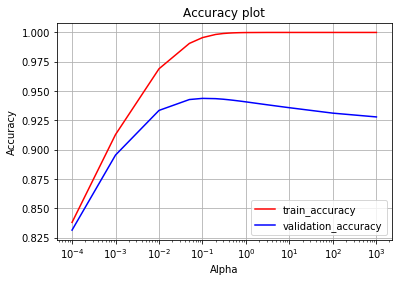

In [31]:
bow_train = finding_best_lambda(X_train_bow,y_train)

# view the complete results (list of named tuples)
print("=======Training========")
print (bow_train.best_score_)
print (bow_train.best_params_)
print (bow_train.best_estimator_)

plotAccuracyGraph(bow_train)

### Applying Logistic Regression with L1 regularization on BOW

/home/pranay/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))



Optimal best alpha is : 0.1

Confusion Matrix for Train data


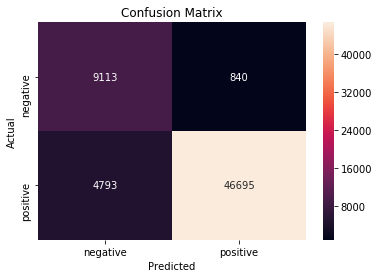


Confusion Matrix for Test data


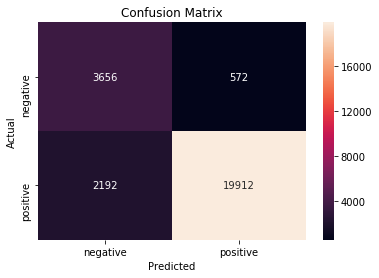

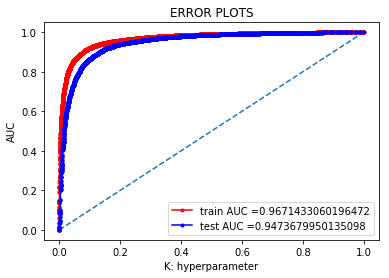


AUC (Train): 0.9671433060196472

AUC (Test): 0.9473679950135098

F1 SCORE (Train) : 0.9431142259879017

F1 SCORE (Test) : 0.9350990889452427

RECALL (Train): 0.9069103480422622

RECALL (Test): 0.9008324285197249

PRECISION  (Train) : 0.9823288103502682

PRECISION  (Test) : 0.9720757664518649


In [32]:
optimal_alpha = bow_train.best_params_.get('C')

optimal_lr_L1 = LogisticRegression(C=optimal_alpha, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=-1, penalty= 'l1', random_state=1,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)
# fitting the model
optimal_lr_L1.fit(X_train_bow,y_train)

# predict the response
test_pred = optimal_lr_L1.predict(x_test_bow)
train_pred = optimal_lr_L1.predict(X_train_bow)

print('\n'+color.RED+'Optimal best alpha is : '+color.END+color.BOLD+str(optimal_alpha)+color.END)

# plot confusion matrix

print('\n'+color.BOLD +'Confusion Matrix for Train data'+color.END)
plotConfusionMatrix(y_train,train_pred)

print('\n'+color.BOLD +'Confusion Matrix for Test data'+color.END)
plotConfusionMatrix(y_test,test_pred)

# plot AUC
train_auc,test_auc = plotAUC_ROC(optimal_lr_L1,X_train_bow, y_train,x_test_bow, y_test )
print('\n'+color.RED+'AUC (Train): '+color.END+color.BOLD+str(train_auc)+color.END)
print('\n'+color.RED+'AUC (Test): '+color.END+color.BOLD+str(test_auc)+color.END)

# f1 score
score = f1_score(y_test,test_pred)
print('\n'+color.RED+'F1 SCORE (Train) : '+color.END+color.BOLD+str(f1_score(y_train,train_pred))+color.END)
print('\n'+color.RED+'F1 SCORE (Test) : '+color.END+color.BOLD+str(score)+color.END)

# recall
recall = metrics.recall_score(y_test, test_pred)
print('\n'+color.RED+'RECALL (Train): '+color.END+color.BOLD+str(metrics.recall_score(y_train, train_pred))+color.END)
print('\n'+color.RED+'RECALL (Test): '+color.END+color.BOLD+str(recall)+color.END)

# precision
precision = metrics.precision_score(y_test, test_pred)
print('\n'+color.RED+'PRECISION  (Train) : '+color.END+color.BOLD+str(metrics.precision_score(y_train, train_pred))+color.END)
print('\n'+color.RED+'PRECISION  (Test) : '+color.END+color.BOLD+str(precision)+color.END)

### Applying Logistic Regression with L2 regularization on BOW

/home/pranay/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))



Optimal best alpha is : 0.1

Confusion Matrix for Train data


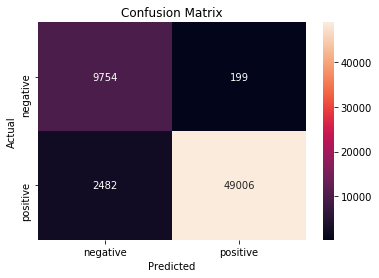


Confusion Matrix for Test data


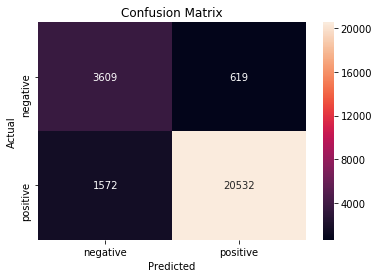

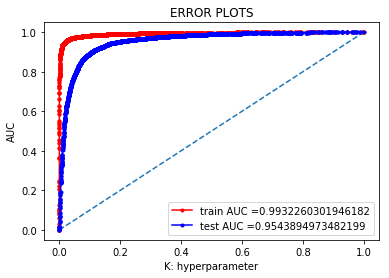


AUC (Train): 0.9932260301946182

AUC (Test): 0.9543894973482199

F1 SCORE (Train) : 0.9733745146137269

F1 SCORE (Test) : 0.949346896312565

RECALL (Train): 0.9517945929148539

RECALL (Test): 0.9288816503800217

PRECISION  (Train) : 0.9959556955593943

PRECISION  (Test) : 0.970734244243771


In [33]:
optimal_alpha = bow_train.best_params_.get('C')

optimal_lr_L2 = LogisticRegression(C=optimal_alpha, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=-1, penalty='l2', random_state=0,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

# fitting the model
optimal_lr_L2.fit(X_train_bow,y_train)

# predict the response
test_pred = optimal_lr_L2.predict(x_test_bow)
train_pred = optimal_lr_L2.predict(X_train_bow)

print('\n'+color.RED+'Optimal best alpha is : '+color.END+color.BOLD+str(optimal_alpha)+color.END)

# plot confusion matrix

print('\n'+color.BOLD +'Confusion Matrix for Train data'+color.END)
plotConfusionMatrix(y_train,train_pred)

print('\n'+color.BOLD +'Confusion Matrix for Test data'+color.END)
plotConfusionMatrix(y_test,test_pred)

# plot AUC
train_auc,test_auc = plotAUC_ROC(optimal_lr_L2,X_train_bow, y_train,x_test_bow, y_test )
print('\n'+color.RED+'AUC (Train): '+color.END+color.BOLD+str(train_auc)+color.END)
print('\n'+color.RED+'AUC (Test): '+color.END+color.BOLD+str(test_auc)+color.END)

# f1 score
score = f1_score(y_test,test_pred)
print('\n'+color.RED+'F1 SCORE (Train) : '+color.END+color.BOLD+str(f1_score(y_train,train_pred))+color.END)
print('\n'+color.RED+'F1 SCORE (Test) : '+color.END+color.BOLD+str(score)+color.END)

# recall
recall = metrics.recall_score(y_test, test_pred)
print('\n'+color.RED+'RECALL (Train): '+color.END+color.BOLD+str(metrics.recall_score(y_train, train_pred))+color.END)
print('\n'+color.RED+'RECALL (Test): '+color.END+color.BOLD+str(recall)+color.END)

# precision
precision = metrics.precision_score(y_test, test_pred)
print('\n'+color.RED+'PRECISION  (Train) : '+color.END+color.BOLD+str(metrics.precision_score(y_train, train_pred))+color.END)
print('\n'+color.RED+'PRECISION  (Test) : '+color.END+color.BOLD+str(precision)+color.END)

### Top 10 important features of positive class
### Top 10 important features of negative class

In [34]:
show_most_informative_features(count_vect.get_feature_names(), optimal_lr_L1, 10)

Important words in negative reviews

-2.400606018512812 not worth
-2.284585213544531 worst
-2.1598353014059155 not recommend
-2.0737712926231207 disappointing
-1.9845486432905277 rip
-1.888282378277612 two stars
-1.8589848847676638 disappointment
-1.7885460261825736 disappointed
-1.7721594831212173 not happy
-1.6381050066270364 definitely not
-----------------------------------------

Important words in positive reviews

3.4147735830187753 not disappointed
2.1566946899804167 pleasantly
1.6845859816976225 not bitter
1.6486653587542444 hooked
1.541704086540122 yummy
1.5311706680175912 delicious
1.5278140542800749 perfect
1.4398713231834108 excellent
1.3604636271016937 awesome
1.3481272069764434 right amount


### Sparsitiy

In [35]:
# non zero
print("\n"+color.RED+"NON ZERO weights for L1 Regularizer: "+color.END+color.BOLD+ str(np.count_nonzero(optimal_lr_L1.coef_))+color.END)
# non zero
print("\n"+color.RED+"NON ZERO weights for L2 Regularizer : "+color.END+color.BOLD+ str(np.count_nonzero(optimal_lr_L2.coef_))+color.END)


NON ZERO weights for L1 Regularizer: 1363

NON ZERO weights for L2 Regularizer : 36487


### Multicolinearity check using pertubation test

In [36]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.find.html
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html

from scipy.stats import uniform
from scipy.sparse import find
X_train_noise = X_train_bow

#Random noise
epsilon = np.random.uniform(low=-0.0001, high=0.0001, size=(find(X_train_noise)[0].size,))

# find --> I,J, and V contain the row indices, column indices, and values of the nonzero matrix entries.
I,J,V = find(X_train_noise)

#Introducing random noise to non-zero datapoints
X_train_noise[I,J] = epsilon + X_train_noise[I,J]

optimal_lr_noise = LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=-1, penalty='l1', random_state=0,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

# fit noisy data
optimal_lr_noise.fit(X_train_noise,y_train)

y_pred = optimal_lr_noise.predict(x_test_bow)

# Vector WITHOUT noisy
W_before_epsilon = optimal_lr_L1.coef_


# Vector WITH noisy
W_after_epsilon = optimal_lr_noise.coef_

# adding small very eps to W_before_epsilon (to eliminate the divisible by zero error)
W_before_epsilon += W_before_epsilon + 1e-6
W_after_epsilon += W_after_epsilon + 1e-6

percentage_change_vector = abs( (W_before_epsilon-W_after_epsilon) / (W_before_epsilon) )*100

/home/pranay/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


/home/pranay/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
No handles with labels found to put in legend.


0 th percentile :  0.0
10 th percentile :  0.0
20 th percentile :  0.0
30 th percentile :  0.0
40 th percentile :  0.0
50 th percentile :  0.0
60 th percentile :  0.0
70 th percentile :  0.0
80 th percentile :  0.0
90 th percentile :  0.0
100 th percentile :  153251830.22843093


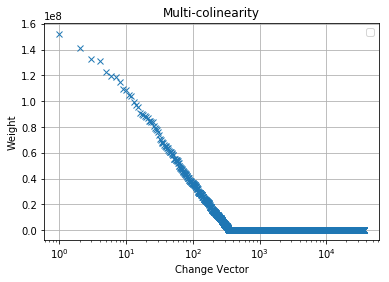

In [37]:
feature_range = range(0,101,10)
for i in feature_range:
    print(i, "th percentile : ",np.percentile(percentage_change_vector,i))

# Change in vectors after adding epsilon
# Sort this change_vector array after making all the elements positive in ascending order to visualize the change
sorted_change_vector = np.sort(np.absolute(percentage_change_vector))[:,::-1]
range_graph = sorted_change_vector.shape[1]
weight_drop = sorted_change_vector[0,0:range_graph]
ar = np.arange(range_graph) # just as an example array
plt.semilogx(ar, np.zeros_like(ar) + weight_drop, 'x')
plt.title('Multi-colinearity')
plt.xlabel('Change Vector')
plt.ylabel('Weight')
plt.grid('on')
plt.legend()
plt.show()

In [38]:
feature_range = range(90,101,1)
for i in feature_range:
    print(i, "th percentile : ",np.percentile(percentage_change_vector,i))

90 th percentile :  0.0
91 th percentile :  0.0
92 th percentile :  0.0
93 th percentile :  0.0
94 th percentile :  0.0
95 th percentile :  0.0
96 th percentile :  18.747859460330154
97 th percentile :  60.300373312143094
98 th percentile :  100.00015900251142
99 th percentile :  1847.587590853798
100 th percentile :  153251830.22843093


In [39]:
feature_range = np.linspace(99,100,10)
for i in feature_range:
    print(i, "th percentile : ",np.percentile(percentage_change_vector,i))

99.0 th percentile :  1847.587590853798
99.11111111111111 th percentile :  2618928.839099335
99.22222222222223 th percentile :  6220160.50884307
99.33333333333333 th percentile :  10685960.462668365
99.44444444444444 th percentile :  14706099.515865125
99.55555555555556 th percentile :  22289521.513356917
99.66666666666667 th percentile :  29555938.969730396
99.77777777777777 th percentile :  42302776.875304565
99.88888888888889 th percentile :  64076925.07764573
100.0 th percentile :  153251830.22843093


In [98]:
diff = (abs(W_before_epsilon - W_after_epsilon)/W_before_epsilon) * 100
q = diff[np.where(diff > 95)].size
print("Features are not changing much after 95,skip those features and check the difference, which is (in %) :",(W_before_epsilon.size - q)/W_before_epsilon.size*100)

Features are not changing much after 95,skip those features and check the difference, which is (in %) : 98.30624606024062


### Feature Engineering

Till now we only consider Text review as feature, we are adding some extra feature like __review summary__ and __number of words__ in review and test our model improves efficiency or not.

We have considered on 50000 points due to memory issue.

(35000, 13) (15000, 13) (35000,) (15000,)


/home/pranay/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))



Confusion Matrix for Train data


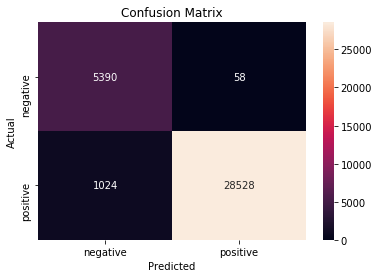


Confusion Matrix for Test data


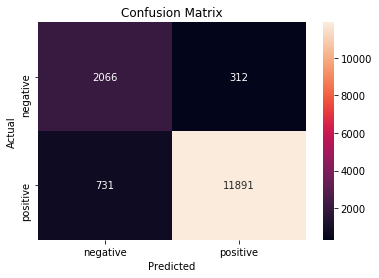

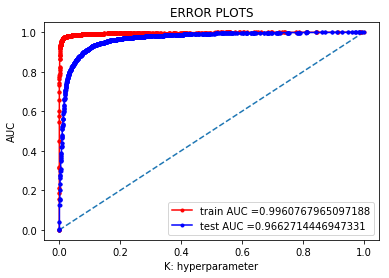


AUC (Train): 0.9960767965097188

AUC (Test): 0.9662714446947331

F1 SCORE (Train) : 0.981389108672469

F1 SCORE (Test) : 0.9579859013091642

RECALL (Train): 0.9653492149431511

RECALL (Test): 0.9420852479797179

PRECISION  (Train) : 0.9979710347722661

PRECISION  (Test) : 0.9744325165942801


In [41]:
# https://sondosatwi.wordpress.com/2017/08/01/using-text-data-and-dataframemapper-in-python/

X = final[:50000]
y = final['Score'][:50000]

# split the data set into train and test
X_train, x_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3,random_state=0)

print(X_train.shape, x_test.shape, y_train.shape, y_test.shape)

mapper = DataFrameMapper([
     ('preprocessed_reviews', CountVectorizer(ngram_range=(1,3), min_df=10)),
     ('preprocessed_summary', CountVectorizer(ngram_range=(1,3), min_df=10)),
     ('numbers_of_words', None),
 ])

train_features = mapper.fit_transform(X_train)
test_features = mapper.transform(x_test)

optimal_alpha = bow_train.best_params_.get('C')

optimal_lr = LogisticRegression(C=optimal_alpha, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=-1, penalty='l2', random_state=0,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

# fitting the model
optimal_lr.fit(train_features,y_train)

# predict the response
test_pred = optimal_lr.predict(test_features)
train_pred = optimal_lr.predict(train_features)

# plot confusion matrix

print('\n'+color.BOLD +'Confusion Matrix for Train data'+color.END)
plotConfusionMatrix(y_train,train_pred)

print('\n'+color.BOLD +'Confusion Matrix for Test data'+color.END)
plotConfusionMatrix(y_test,test_pred)

# plot AUC
train_auc,test_auc = plotAUC_ROC(optimal_lr,train_features, y_train,test_features, y_test )
print('\n'+color.RED+'AUC (Train): '+color.END+color.BOLD+str(train_auc)+color.END)
print('\n'+color.RED+'AUC (Test): '+color.END+color.BOLD+str(test_auc)+color.END)

# f1 score
score = f1_score(y_test,test_pred)
print('\n'+color.RED+'F1 SCORE (Train) : '+color.END+color.BOLD+str(f1_score(y_train,train_pred))+color.END)
print('\n'+color.RED+'F1 SCORE (Test) : '+color.END+color.BOLD+str(score)+color.END)

# recall
recall = metrics.recall_score(y_test, test_pred)
print('\n'+color.RED+'RECALL (Train): '+color.END+color.BOLD+str(metrics.recall_score(y_train, train_pred))+color.END)
print('\n'+color.RED+'RECALL (Test): '+color.END+color.BOLD+str(recall)+color.END)

# precision
precision = metrics.precision_score(y_test, test_pred)
print('\n'+color.RED+'PRECISION  (Train) : '+color.END+color.BOLD+str(metrics.precision_score(y_train, train_pred))+color.END)
print('\n'+color.RED+'PRECISION  (Test) : '+color.END+color.BOLD+str(precision)+color.END)

It can be observed that using __review summary__ and __numbers of word__ in review text, AUC value has increase. Without feature engineering it was __0.947__ and with feature engineering its __0.96627__

In [42]:
merged_features_vectorizer = mapper.features[0][1].get_feature_names() + mapper.features[1][1].get_feature_names()
show_most_informative_features(merged_features_vectorizer, optimal_lr, 10)

Important words in negative reviews

-1.8544229030855808 not
-1.541873509705295 not good
-1.3909389284357616 disappointed
-1.3744626023302036 worst
-1.2720116076879624 disappointed
-1.21383618399322 not worth
-1.1961239087510251 disappointing
-1.14327861492653 terrible
-1.1103088219439883 horrible
-1.0972134846411266 not recommend
-----------------------------------------

Important words in positive reviews

1.873319655948151 best
1.7685304439378438 great
1.7263636609204331 excellent
1.6201664612153495 delicious
1.4997014410948841 good
1.4613373003414647 not bad
1.442104914837869 yummy
1.3870496978934115 delicious
1.2613129890091792 love
1.2400271944266943 tasty


## [4.3] TF-IDF

In [43]:
X = final['preprocessed_reviews']
y = final['Score']

# split the data set into train and test
X_train, x_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3,random_state=0)

print(X_train.shape, x_test.shape, y_train.shape, y_test.shape)

tf_idf_vect = TfidfVectorizer(ngram_range=(1,3), min_df=10) #in scikit-learn

# train data
X_train_tfidf = tf_idf_vect.fit_transform(X_train)

# test data
x_test_tfidf = tf_idf_vect.transform(x_test)

print('X_train_tfidf', X_train_tfidf.shape)
print('==='*10)
print('x_test_tfidf', x_test_tfidf.shape)

(61441,) (26332,) (61441,) (26332,)
X_train_tfidf (61441, 40217)
x_test_tfidf (26332, 40217)


##  Applying Logistic Regression on TFIDF

Fitting 10 folds for each of 21 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0852s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Batch computation too slow (2.0862s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Batch computation too slow (2.7629s.) Setting batch_size=1.
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 101 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 123 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done 149 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done 164 tasks      | elapsed:  

=======Training========
0.9569158183079963
{'C': 5}
LogisticRegression(C=5, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=-1, penalty='l2', random_state=1,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)


/home/pranay/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


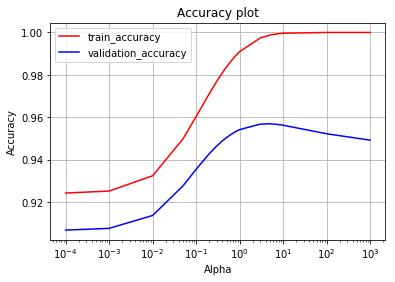

In [44]:
tfidf_train = finding_best_lambda(X_train_tfidf,y_train)

# view the complete results (list of named tuples)
print("=======Training========")
print (tfidf_train.best_score_)
print (tfidf_train.best_params_)
print (tfidf_train.best_estimator_)

plotAccuracyGraph(tfidf_train)

### Applying Logistic Regression with L1 regularization on TFIDF


Optimal best alpha is : 5
[LibLinear]

/home/pranay/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))



Confusion Matrix for Train data


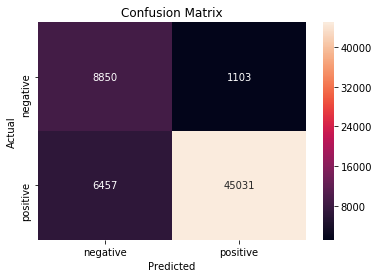


Confusion Matrix for Test data


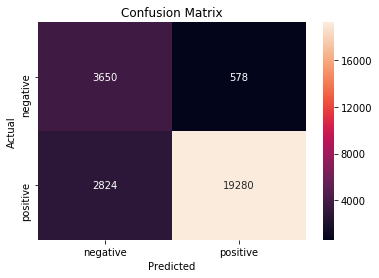

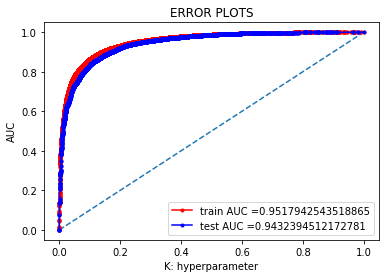


AUC (Train): 0.9517942543518865

AUC (Test): 0.9432394512172781

F1 SCORE (Train) : 0.9225584396959702

F1 SCORE (Test) : 0.9189266479195464

RECALL (Train): 0.8745921379738968

RECALL (Test): 0.8722403184943902

PRECISION  (Train) : 0.9760913859626306

PRECISION  (Test) : 0.9708933427334072


In [78]:
optimal_alpha = tfidf_train.best_params_.get('C')

print('\n'+color.RED+'Optimal best alpha is : '+color.END+color.BOLD+str(optimal_alpha)+color.END)

optimal_lr_L1 = LogisticRegression(C=0.25, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=-1, penalty= 'l1', random_state=1,
          solver='warn', tol=0.0001, verbose=1, warm_start=False)
# fitting the model
optimal_lr_L1.fit(X_train_tfidf,y_train)

# predict the response
test_pred = optimal_lr_L1.predict(x_test_tfidf)
train_pred = optimal_lr_L1.predict(X_train_tfidf)

# plot confusion matrix

print('\n'+color.BOLD +'Confusion Matrix for Train data'+color.END)
plotConfusionMatrix(y_train,train_pred)

print('\n'+color.BOLD +'Confusion Matrix for Test data'+color.END)
plotConfusionMatrix(y_test,test_pred)

# plot AUC
train_auc,test_auc = plotAUC_ROC(optimal_lr_L1,X_train_tfidf, y_train,x_test_tfidf, y_test )
print('\n'+color.RED+'AUC (Train): '+color.END+color.BOLD+str(train_auc)+color.END)
print('\n'+color.RED+'AUC (Test): '+color.END+color.BOLD+str(test_auc)+color.END)

# f1 score
score = f1_score(y_test,test_pred)
print('\n'+color.RED+'F1 SCORE (Train) : '+color.END+color.BOLD+str(f1_score(y_train,train_pred))+color.END)
print('\n'+color.RED+'F1 SCORE (Test) : '+color.END+color.BOLD+str(score)+color.END)

# recall
recall = metrics.recall_score(y_test, test_pred)
print('\n'+color.RED+'RECALL (Train): '+color.END+color.BOLD+str(metrics.recall_score(y_train, train_pred))+color.END)
print('\n'+color.RED+'RECALL (Test): '+color.END+color.BOLD+str(recall)+color.END)

# precision
precision = metrics.precision_score(y_test, test_pred)
print('\n'+color.RED+'PRECISION  (Train) : '+color.END+color.BOLD+str(metrics.precision_score(y_train, train_pred))+color.END)
print('\n'+color.RED+'PRECISION  (Test) : '+color.END+color.BOLD+str(precision)+color.END)

### Applying Logistic Regression with L2 regularization on TFIDF


Optimal best alpha is : 5
[LibLinear]

/home/pranay/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))



Confusion Matrix for Train data


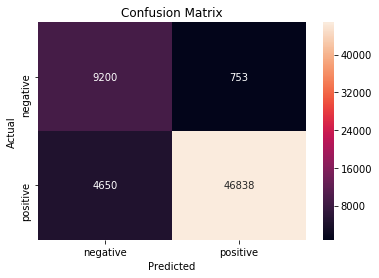


Confusion Matrix for Test data


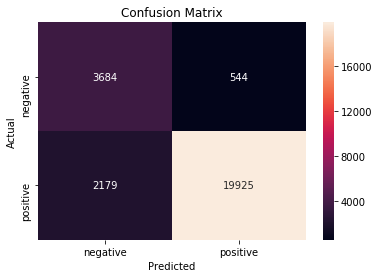

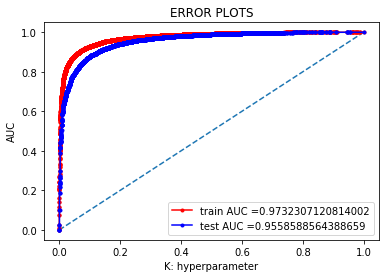


AUC (Train): 0.9732307120814002

AUC (Test): 0.9558588564388659

F1 SCORE (Train) : 0.9454677580516556

F1 SCORE (Test) : 0.9360392737180842

RECALL (Train): 0.9096876942200124

RECALL (Test): 0.9014205573651828

PRECISION  (Train) : 0.9841776806539051

PRECISION  (Test) : 0.9734232253651863


In [77]:
optimal_alpha = tfidf_train.best_params_.get('C')

print('\n'+color.RED+'Optimal best alpha is : '+color.END+color.BOLD+str(optimal_alpha)+color.END)

optimal_lr_L2 = LogisticRegression(C=0.25, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=-1, penalty= 'l2', random_state=1,
          solver='warn', tol=0.0001, verbose=1, warm_start=False)
# fitting the model
optimal_lr_L2.fit(X_train_tfidf,y_train)

# predict the response
test_pred = optimal_lr_L2.predict(x_test_tfidf)
train_pred = optimal_lr_L2.predict(X_train_tfidf)

# plot confusion matrix

print('\n'+color.BOLD +'Confusion Matrix for Train data'+color.END)
plotConfusionMatrix(y_train,train_pred)

print('\n'+color.BOLD +'Confusion Matrix for Test data'+color.END)
plotConfusionMatrix(y_test,test_pred)

# plot AUC
train_auc,test_auc = plotAUC_ROC(optimal_lr_L2,X_train_tfidf, y_train,x_test_tfidf, y_test )
print('\n'+color.RED+'AUC (Train): '+color.END+color.BOLD+str(train_auc)+color.END)
print('\n'+color.RED+'AUC (Test): '+color.END+color.BOLD+str(test_auc)+color.END)

# f1 score
score = f1_score(y_test,test_pred)
print('\n'+color.RED+'F1 SCORE (Train) : '+color.END+color.BOLD+str(f1_score(y_train,train_pred))+color.END)
print('\n'+color.RED+'F1 SCORE (Test) : '+color.END+color.BOLD+str(score)+color.END)

# recall
recall = metrics.recall_score(y_test, test_pred)
print('\n'+color.RED+'RECALL (Train): '+color.END+color.BOLD+str(metrics.recall_score(y_train, train_pred))+color.END)
print('\n'+color.RED+'RECALL (Test): '+color.END+color.BOLD+str(recall)+color.END)

# precision
precision = metrics.precision_score(y_test, test_pred)
print('\n'+color.RED+'PRECISION  (Train) : '+color.END+color.BOLD+str(metrics.precision_score(y_train, train_pred))+color.END)
print('\n'+color.RED+'PRECISION  (Test) : '+color.END+color.BOLD+str(precision)+color.END)

In [79]:
show_most_informative_features(tf_idf_vect.get_feature_names(), optimal_lr_L1, 10)

Important words in negative reviews

-14.114648028322517 disappointed
-13.349887987005994 worst
-12.538581101588191 not worth
-12.066794922704553 not recommend
-10.918908138524769 disappointing
-10.546870450505201 not good
-10.266737830409385 disappointment
-10.04600596547169 terrible
-9.711163445381478 awful
-9.65427103613546 unfortunately
-----------------------------------------

Important words in positive reviews

18.541721562618662 great
16.39234175505932 not disappointed
15.731065262295605 delicious
14.392228464113455 perfect
13.913293481992001 best
11.64344612658123 good
11.51605909605964 excellent
11.196548458432302 loves
10.982341333361717 wonderful
10.063072934336851 nice


### Feature Engineering

Till now we only consider Text review as feature, we are adding some extra feature like __review summary__ and __number of words__ in review and test our model improves efficiency or not.

We have considered on 50000 points due to memory issue.

(35000, 13) (15000, 13) (35000,) (15000,)


/home/pranay/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))



Confusion Matrix for Train data


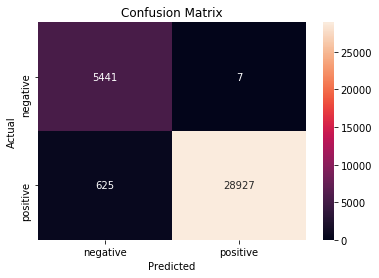


Confusion Matrix for Test data


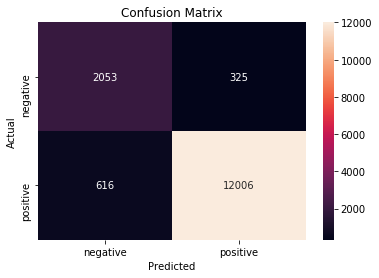

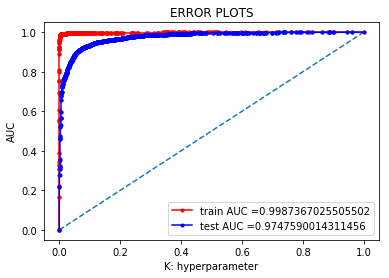


AUC (Train): 0.9987367025505502

AUC (Test): 0.9747590014311456

F1 SCORE (Train) : 0.9891939951441371

F1 SCORE (Test) : 0.9622891035146074

RECALL (Train): 0.9788508391987006

RECALL (Test): 0.9511963238789415

PRECISION  (Train) : 0.999758070090551

PRECISION  (Test) : 0.973643662314492


In [48]:
# https://sondosatwi.wordpress.com/2017/08/01/using-text-data-and-dataframemapper-in-python/

X = final[:50000]
y = final['Score'][:50000]

# split the data set into train and test
X_train, x_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3,random_state=0)

print(X_train.shape, x_test.shape, y_train.shape, y_test.shape)

mapper = DataFrameMapper([
     ('preprocessed_reviews', TfidfVectorizer(ngram_range=(1,2), min_df=10)),
     ('preprocessed_summary', TfidfVectorizer(ngram_range=(1,2), min_df=10)),
     ('numbers_of_words', None),
 ])

train_features = mapper.fit_transform(X_train)
test_features = mapper.transform(x_test)

optimal_alpha = tfidf_train.best_params_.get('C')

optimal_lr = LogisticRegression(C=optimal_alpha, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=-1, penalty='l2', random_state=0,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

# fitting the model
optimal_lr.fit(train_features,y_train)

# predict the response
test_pred = optimal_lr.predict(test_features)
train_pred = optimal_lr.predict(train_features)

# plot confusion matrix

print('\n'+color.BOLD +'Confusion Matrix for Train data'+color.END)
plotConfusionMatrix(y_train,train_pred)

print('\n'+color.BOLD +'Confusion Matrix for Test data'+color.END)
plotConfusionMatrix(y_test,test_pred)

# plot AUC
train_auc,test_auc = plotAUC_ROC(optimal_lr,train_features, y_train,test_features, y_test )
print('\n'+color.RED+'AUC (Train): '+color.END+color.BOLD+str(train_auc)+color.END)
print('\n'+color.RED+'AUC (Test): '+color.END+color.BOLD+str(test_auc)+color.END)

# f1 score
score = f1_score(y_test,test_pred)
print('\n'+color.RED+'F1 SCORE (Train) : '+color.END+color.BOLD+str(f1_score(y_train,train_pred))+color.END)
print('\n'+color.RED+'F1 SCORE (Test) : '+color.END+color.BOLD+str(score)+color.END)

# recall
recall = metrics.recall_score(y_test, test_pred)
print('\n'+color.RED+'RECALL (Train): '+color.END+color.BOLD+str(metrics.recall_score(y_train, train_pred))+color.END)
print('\n'+color.RED+'RECALL (Test): '+color.END+color.BOLD+str(recall)+color.END)

# precision
precision = metrics.precision_score(y_test, test_pred)
print('\n'+color.RED+'PRECISION  (Train) : '+color.END+color.BOLD+str(metrics.precision_score(y_train, train_pred))+color.END)
print('\n'+color.RED+'PRECISION  (Test) : '+color.END+color.BOLD+str(precision)+color.END)

It can be observed that using __review summary__ and __numbers of word__ in review text, AUC value has increase. Without feature engineering it was __0.94327__ and with feature engineering its __0.974759__

In [49]:
merged_features_vectorizer = mapper.features[0][1].get_feature_names() + mapper.features[1][1].get_feature_names()
show_most_informative_features(merged_features_vectorizer, optimal_lr, 10)

Important words in negative reviews

-9.857509030987528 disappointed
-7.244593020001361 not
-7.200016578121558 worst
-6.903939712938978 disappointing
-6.820379638917684 not worth
-6.764746595058198 horrible
-6.674548153793532 not recommend
-6.391857740086196 not good
-6.241702533771523 terrible
-6.08989356023899 threw
-----------------------------------------

Important words in positive reviews

11.36860593542519 great
9.98699691446001 delicious
8.94103383916089 best
8.450486514051818 good
7.500938516056907 excellent
7.14165100978573 loves
7.096228695680909 wonderful
6.95709813914174 not bad
6.392061102694969 excellent
6.303538999338141 love


## [4.4] Word2Vec

In [50]:
X = final['preprocessed_reviews']
y = final['Score']

# split the data set into train and test
X_train, x_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3,random_state=0)

print(X_train.shape, x_test.shape, y_train.shape, y_test.shape)

(61441,) (26332,) (61441,) (26332,)


In [51]:
# Train your own Word2Vec model using your own text corpus

# Train data
list_of_sentance=[]
for sentance in X_train:
    list_of_sentance.append(sentance.split())

# Test data
list_of_test_sentence = []
for sentance in x_test:
    list_of_test_sentence.append(sentance.split())

In [52]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    # train data
    w2v_model_tr=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    # train model on test data
    w2v_model_test = Word2Vec(list_of_test_sentence,min_count=5,size=50, workers=4)
    print(w2v_model_tr.wv.most_similar('great'))
    print('='*50)
    print(w2v_model_tr.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('awesome', 0.8481743931770325), ('fantastic', 0.8348914384841919), ('good', 0.8124116659164429), ('terrific', 0.7891563177108765), ('wonderful', 0.7837672829627991), ('excellent', 0.7761527299880981), ('perfect', 0.7479161024093628), ('amazing', 0.7405906915664673), ('nice', 0.6588971614837646), ('fabulous', 0.6407647132873535)]
[('greatest', 0.7771077752113342), ('tastiest', 0.7046787142753601), ('best', 0.7011160850524902), ('nastiest', 0.6469311714172363), ('disgusting', 0.6378945708274841), ('experienced', 0.631453275680542), ('awful', 0.6187647581100464), ('closest', 0.6175501346588135), ('horrible', 0.595188319683075), ('hottest', 0.5755820274353027)]


In [53]:
# train data operation
w2v_train_words = list(w2v_model_tr.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_train_words))
print("sample words ", w2v_train_words[0:50])

number of words that occured minimum 5 times  14910
sample words  ['aroma', 'flavor', 'seem', 'fine', 'weak', 'value', 'used', 'entire', 'bottle', 'quart', 'home', 'made', 'ice', 'cream', 'people', 'guessing', 'not', 'enough', 'licorice', 'spent', 'twice', 'price', 'really', 'concentrated', 'would', 'great', 'never', 'waste', 'money', 'item', 'like', 'shampoo', 'know', 'necessarily', 'hair', 'definitely', 'cleans', 'scalp', 'well', 'also', 'thickest', 'lather', 'ever', 'hellman', 'arguably', 'absolute', 'finest', 'mass', 'market', 'mayonnaise']


In [54]:
# test data operation
w2v_test_words = list(w2v_model_test.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_test_words))
print("sample words ", w2v_test_words[0:50])

number of words that occured minimum 5 times  9806
sample words  ['used', 'use', 'cheaper', 'grocery', 'store', 'brands', 'two', 'cats', 'got', 'sick', 'no', 'idea', 'causing', 'changed', 'cat', 'food', 'anyway', 'love', 'healthy', 'made', 'good', 'cheese', 'corn', 'big', 'round', 'fresh', 'popcorn', 'evenly', 'seasoned', 'really', 'cheesy', 'flavor', 'not', 'salty', 'greasy', 'taste', 'sensational', 'ordering', 'disappointment', 'searching', 'awhile', 'find', 'flavored', 'water', 'artificial', 'sweetener', 'kind', 'saw', 'reviews', 'thought']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [57]:
# average Word2Vec

# train data operation
exists = os.path.isfile(avg_w2v_trained_model_100000)
if exists:
    print("yes exist")
    final_w2v_train = load(avg_w2v_trained_model_100000)
else:
    print("not exist")
    # compute average word2vec for each review.
    final_w2v_train = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in tqdm(list_of_sentance): # for each review/sentence
        sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_train_words:
                vec = w2v_model_tr.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        final_w2v_train.append(sent_vec)
    print(len(final_w2v_train))
    print(len(final_w2v_train[0]))
    dump(final_w2v_train,avg_w2v_trained_model_100000)


# test data operation
exists = os.path.isfile(avg_w2v_test_model_100000)
if exists:
    print("yes exist")
    final_w2v_test = load(avg_w2v_test_model_100000)
else:
    print("not exist")
    final_w2v_test = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in tqdm(list_of_test_sentence): # for each review/sentence
        sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_test_words:
                vec = w2v_model_test.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        final_w2v_test.append(sent_vec)
    print(len(final_w2v_test))
    print(len(final_w2v_test[0]))
    dump(final_w2v_test,avg_w2v_test_model_100000)

  0%|          | 95/61441 [00:00<02:08, 476.02it/s]

not exist


100%|██████████| 61441/61441 [02:31<00:00, 405.92it/s]


61441
50


  0%|          | 105/26332 [00:00<00:25, 1044.73it/s]

not exist


100%|██████████| 26332/26332 [00:37<00:00, 705.93it/s]


26332
50


Fitting 10 folds for each of 21 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   35.8s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   48.8s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  4

=======Training========
0.9057955354920413
{'C': 0.05}
LogisticRegression(C=0.05, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=-1, penalty='l2', random_state=1,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)


/home/pranay/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


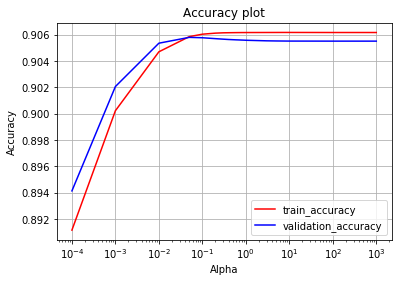

In [58]:
w2v_train = finding_best_lambda(final_w2v_train,y_train)

# view the complete results (list of named tuples)
print("=======Training========")
print (w2v_train.best_score_)
print (w2v_train.best_params_)
print (w2v_train.best_estimator_)

plotAccuracyGraph(w2v_train)

### Applying Logistic Regression with L1 regularization on W2V


Optimal best alpha is : 0.05
[LibLinear]

/home/pranay/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))



Confusion Matrix for Train data


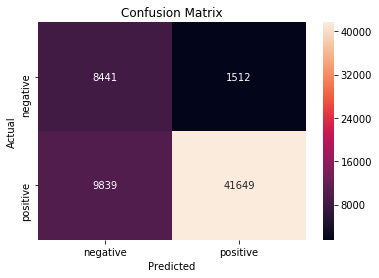


Confusion Matrix for Test data


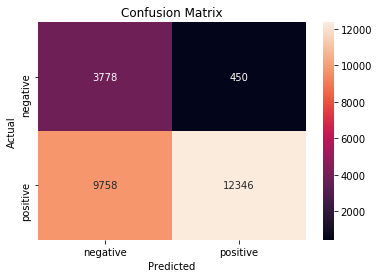

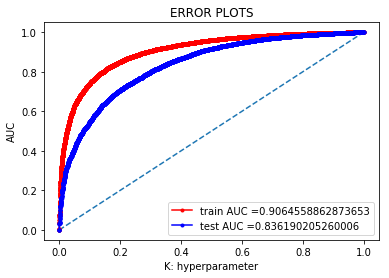


AUC (Train): 0.9064558862873653

AUC (Test): 0.836190205260006

F1 SCORE (Train) : 0.8800726896216546

F1 SCORE (Test) : 0.7075071633237823

RECALL (Train): 0.8089069297700435

RECALL (Test): 0.5585414404632646

PRECISION  (Train) : 0.9649683742267324

PRECISION  (Test) : 0.9648327602375742


In [59]:
optimal_alpha = w2v_train.best_params_.get('C')

print('\n'+color.RED+'Optimal best alpha is : '+color.END+color.BOLD+str(optimal_alpha)+color.END)

optimal_lr_L1 = LogisticRegression(C=optimal_alpha, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=-1, penalty= 'l1', random_state=1,
          solver='warn', tol=0.0001, verbose=1, warm_start=False)
# fitting the model
optimal_lr_L1.fit(final_w2v_train,y_train)

# predict the response
test_pred = optimal_lr_L1.predict(final_w2v_test)
train_pred = optimal_lr_L1.predict(final_w2v_train)

# plot confusion matrix

print('\n'+color.BOLD +'Confusion Matrix for Train data'+color.END)
plotConfusionMatrix(y_train,train_pred)

print('\n'+color.BOLD +'Confusion Matrix for Test data'+color.END)
plotConfusionMatrix(y_test,test_pred)

# plot AUC
train_auc,test_auc = plotAUC_ROC(optimal_lr_L1,final_w2v_train, y_train,final_w2v_test, y_test )
print('\n'+color.RED+'AUC (Train): '+color.END+color.BOLD+str(train_auc)+color.END)
print('\n'+color.RED+'AUC (Test): '+color.END+color.BOLD+str(test_auc)+color.END)

# f1 score
score = f1_score(y_test,test_pred)
print('\n'+color.RED+'F1 SCORE (Train) : '+color.END+color.BOLD+str(f1_score(y_train,train_pred))+color.END)
print('\n'+color.RED+'F1 SCORE (Test) : '+color.END+color.BOLD+str(score)+color.END)

# recall
recall = metrics.recall_score(y_test, test_pred)
print('\n'+color.RED+'RECALL (Train): '+color.END+color.BOLD+str(metrics.recall_score(y_train, train_pred))+color.END)
print('\n'+color.RED+'RECALL (Test): '+color.END+color.BOLD+str(recall)+color.END)

# precision
precision = metrics.precision_score(y_test, test_pred)
print('\n'+color.RED+'PRECISION  (Train) : '+color.END+color.BOLD+str(metrics.precision_score(y_train, train_pred))+color.END)
print('\n'+color.RED+'PRECISION  (Test) : '+color.END+color.BOLD+str(precision)+color.END)

### Applying Logistic Regression with L2 regularization on W2V


Optimal best alpha is : 0.05
[LibLinear]

/home/pranay/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))



Confusion Matrix for Train data


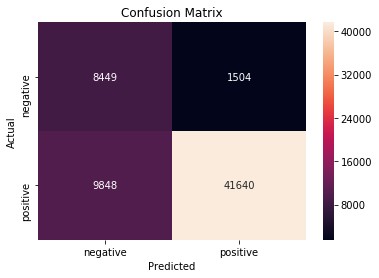


Confusion Matrix for Test data


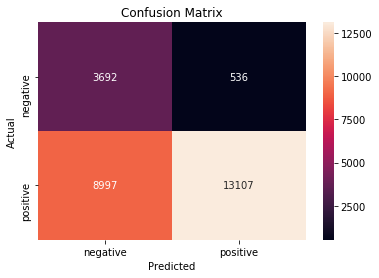

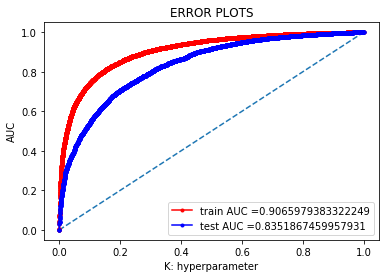


AUC (Train): 0.9065979383322249

AUC (Test): 0.8351867459957931

F1 SCORE (Train) : 0.8800405782399188

F1 SCORE (Test) : 0.7333202786247798

RECALL (Train): 0.8087321317588564

RECALL (Test): 0.5929695982627579

PRECISION  (Train) : 0.9651399962914889

PRECISION  (Test) : 0.9607124532727406


In [60]:
optimal_alpha = w2v_train.best_params_.get('C')

print('\n'+color.RED+'Optimal best alpha is : '+color.END+color.BOLD+str(optimal_alpha)+color.END)

optimal_lr_L2 = LogisticRegression(C=optimal_alpha, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=-1, penalty= 'l2', random_state=1,
          solver='warn', tol=0.0001, verbose=1, warm_start=False)
# fitting the model
optimal_lr_L2.fit(final_w2v_train,y_train)

# predict the response
test_pred = optimal_lr_L2.predict(final_w2v_test)
train_pred = optimal_lr_L2.predict(final_w2v_train)

# plot confusion matrix

print('\n'+color.BOLD +'Confusion Matrix for Train data'+color.END)
plotConfusionMatrix(y_train,train_pred)

print('\n'+color.BOLD +'Confusion Matrix for Test data'+color.END)
plotConfusionMatrix(y_test,test_pred)

# plot AUC
train_auc,test_auc = plotAUC_ROC(optimal_lr_L2,final_w2v_train, y_train,final_w2v_test, y_test )
print('\n'+color.RED+'AUC (Train): '+color.END+color.BOLD+str(train_auc)+color.END)
print('\n'+color.RED+'AUC (Test): '+color.END+color.BOLD+str(test_auc)+color.END)

# f1 score
score = f1_score(y_test,test_pred)
print('\n'+color.RED+'F1 SCORE (Train) : '+color.END+color.BOLD+str(f1_score(y_train,train_pred))+color.END)
print('\n'+color.RED+'F1 SCORE (Test) : '+color.END+color.BOLD+str(score)+color.END)

# recall
recall = metrics.recall_score(y_test, test_pred)
print('\n'+color.RED+'RECALL (Train): '+color.END+color.BOLD+str(metrics.recall_score(y_train, train_pred))+color.END)
print('\n'+color.RED+'RECALL (Test): '+color.END+color.BOLD+str(recall)+color.END)

# precision
precision = metrics.precision_score(y_test, test_pred)
print('\n'+color.RED+'PRECISION  (Train) : '+color.END+color.BOLD+str(metrics.precision_score(y_train, train_pred))+color.END)
print('\n'+color.RED+'PRECISION  (Test) : '+color.END+color.BOLD+str(precision)+color.END)

## [4.4.1.2] TFIDF weighted W2v

In [61]:
X = final['preprocessed_reviews']
y = final['Score']

# split the data set into train and test
X_train, x_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3,random_state=0)

print(X_train.shape, x_test.shape, y_train.shape, y_test.shape)

(61441,) (26332,) (61441,) (26332,)


In [62]:
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tf_idf_vect.get_feature_names(), list(tf_idf_vect.idf_)))

# TF-IDF weighted Word2Vec

# Train data operation

# store model to hard disk if exist then load model directly from memory
exists = os.path.isfile(w2v_tf_idf_trained_model_100000)
if exists:
    print("yes exist")
    final_tfidf_w2v_tr = load(w2v_tf_idf_trained_model_100000)
else:   
    print("not exist")
    tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
    # final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

    final_tfidf_w2v_tr = []; # the tfidf-w2v for each sentence/review is stored in this list
    row=0;
    for sent in tqdm(list_of_sentance): # for each review/sentence 
        sent_vec = np.zeros(50) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_train_words and word in tfidf_feat:
                vec = w2v_model_tr.wv[word]
    #             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
                # to reduce the computation we are 
                # dictionary[word] = idf value of word in whole courpus
                # sent.count(word) = tf valeus of word in this review
                tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        final_tfidf_w2v_tr.append(sent_vec)
        row += 1
    dump(final_tfidf_w2v_tr,w2v_tf_idf_trained_model_100000)
    
    
# Test data operation ============

# store model to hard disk if exist then load model directly from memory
exists = os.path.isfile(w2v_tf_idf_test_model_100000)
if exists:
    print("yes exist")
    final_tfidf_w2v_test = load(w2v_tf_idf_test_model_100000) 

else:   
    print("not exist")
    # final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf
    final_tfidf_w2v_test = []; # the tfidf-w2v for each sentence/review is stored in this list
    row=0;
    for sent in tqdm(list_of_test_sentence): # for each review/sentence 
        sent_vec = np.zeros(50) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_test_words and word in tfidf_feat:
                vec = w2v_model_test.wv[word]
    #             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
                # to reduce the computation we are 
                # dictionary[word] = idf value of word in whole courpus
                # sent.count(word) = tf valeus of word in this review
                tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        final_tfidf_w2v_test.append(sent_vec)
        row += 1
    dump(final_tfidf_w2v_test,w2v_tf_idf_test_model_100000)
        

  0%|          | 7/61441 [00:00<38:21, 26.69it/s]

not exist


  0%|          | 8/26332 [00:00<12:17, 35.67it/s]

not exist


100%|██████████| 26332/26332 [21:50<00:00, 20.09it/s]


Fitting 10 folds for each of 21 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   36.1s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   49.0s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  4

=======Training========
0.882911072934292
{'C': 0.1}
LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=-1, penalty='l2', random_state=1,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)


/home/pranay/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


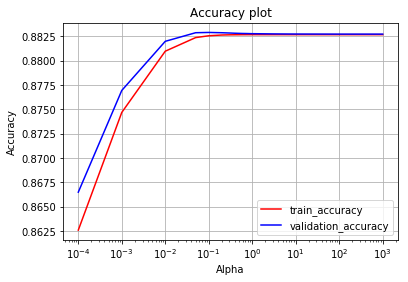

In [63]:
w2v_tfidf_train = finding_best_lambda(final_tfidf_w2v_tr,y_train)

# view the complete results (list of named tuples)
print("=======Training========")
print (w2v_tfidf_train.best_score_)
print (w2v_tfidf_train.best_params_)
print (w2v_tfidf_train.best_estimator_)

plotAccuracyGraph(w2v_tfidf_train) 

### Applying Logistic Regression with L1 regularization on TFIDF-W2V


Optimal best alpha is : 0.1
[LibLinear]

/home/pranay/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))



Confusion Matrix for Train data


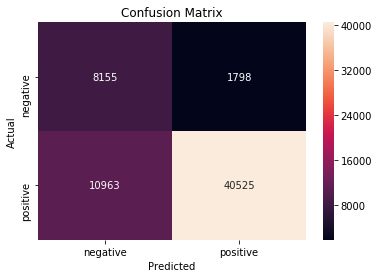


Confusion Matrix for Test data


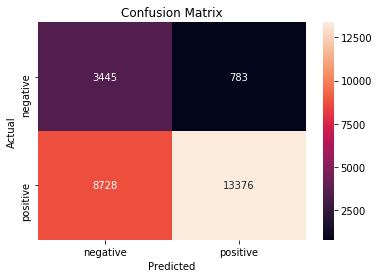

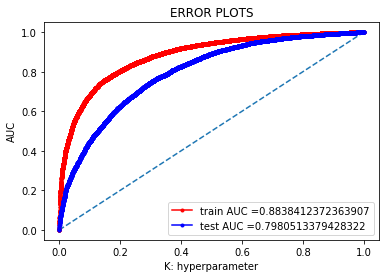


AUC (Train): 0.8838412372363907

AUC (Test): 0.7980513379428322

F1 SCORE (Train) : 0.8639711760880919

F1 SCORE (Test) : 0.7377216446515732

RECALL (Train): 0.7870766003729024

RECALL (Test): 0.6051393412956931

PRECISION  (Train) : 0.9575171892351676

PRECISION  (Test) : 0.9446994844268664


In [64]:
optimal_alpha = w2v_tfidf_train.best_params_.get('C')

print('\n'+color.RED+'Optimal best alpha is : '+color.END+color.BOLD+str(optimal_alpha)+color.END)

optimal_lr_L1 = LogisticRegression(C=optimal_alpha, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=-1, penalty= 'l1', random_state=1,
          solver='warn', tol=0.0001, verbose=1, warm_start=False)
# fitting the model
optimal_lr_L1.fit(final_tfidf_w2v_tr,y_train)

# predict the response
test_pred = optimal_lr_L1.predict(final_tfidf_w2v_test)
train_pred = optimal_lr_L1.predict(final_tfidf_w2v_tr)

# plot confusion matrix

print('\n'+color.BOLD +'Confusion Matrix for Train data'+color.END)
plotConfusionMatrix(y_train,train_pred)

print('\n'+color.BOLD +'Confusion Matrix for Test data'+color.END)
plotConfusionMatrix(y_test,test_pred)

# plot AUC
train_auc,test_auc = plotAUC_ROC(optimal_lr_L1,final_tfidf_w2v_tr, y_train,final_tfidf_w2v_test, y_test )
print('\n'+color.RED+'AUC (Train): '+color.END+color.BOLD+str(train_auc)+color.END)
print('\n'+color.RED+'AUC (Test): '+color.END+color.BOLD+str(test_auc)+color.END)

# f1 score
score = f1_score(y_test,test_pred)
print('\n'+color.RED+'F1 SCORE (Train) : '+color.END+color.BOLD+str(f1_score(y_train,train_pred))+color.END)
print('\n'+color.RED+'F1 SCORE (Test) : '+color.END+color.BOLD+str(score)+color.END)

# recall
recall = metrics.recall_score(y_test, test_pred)
print('\n'+color.RED+'RECALL (Train): '+color.END+color.BOLD+str(metrics.recall_score(y_train, train_pred))+color.END)
print('\n'+color.RED+'RECALL (Test): '+color.END+color.BOLD+str(recall)+color.END)

# precision
precision = metrics.precision_score(y_test, test_pred)
print('\n'+color.RED+'PRECISION  (Train) : '+color.END+color.BOLD+str(metrics.precision_score(y_train, train_pred))+color.END)
print('\n'+color.RED+'PRECISION  (Test) : '+color.END+color.BOLD+str(precision)+color.END)

### Applying Logistic Regression with L2 regularization on TFIDF-W2V


Optimal best alpha is : 0.1
[LibLinear]

/home/pranay/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))



Confusion Matrix for Train data


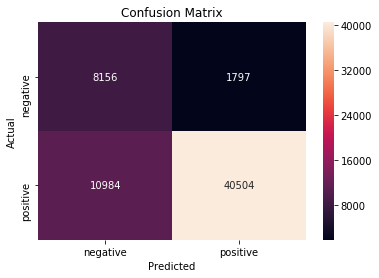


Confusion Matrix for Test data


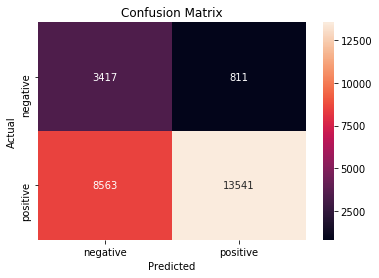

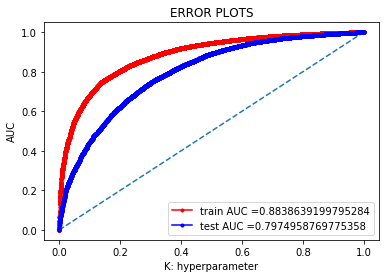


AUC (Train): 0.8838639199795284

AUC (Test): 0.7974958769775358

F1 SCORE (Train) : 0.8637260233076375

F1 SCORE (Test) : 0.7428681149879306

RECALL (Train): 0.7866687383467993

RECALL (Test): 0.6126040535649656

PRECISION  (Train) : 0.9575187347816837

PRECISION  (Test) : 0.9434921962095875


In [65]:
optimal_alpha = w2v_tfidf_train.best_params_.get('C')

print('\n'+color.RED+'Optimal best alpha is : '+color.END+color.BOLD+str(optimal_alpha)+color.END)

optimal_lr_L2 = LogisticRegression(C=optimal_alpha, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=-1, penalty= 'l2', random_state=1,
          solver='warn', tol=0.0001, verbose=1, warm_start=False)
# fitting the model
optimal_lr_L2.fit(final_tfidf_w2v_tr,y_train)

# predict the response
test_pred = optimal_lr_L2.predict(final_tfidf_w2v_test)
train_pred = optimal_lr_L2.predict(final_tfidf_w2v_tr)

# plot confusion matrix

print('\n'+color.BOLD +'Confusion Matrix for Train data'+color.END)
plotConfusionMatrix(y_train,train_pred)

print('\n'+color.BOLD +'Confusion Matrix for Test data'+color.END)
plotConfusionMatrix(y_test,test_pred)

# plot AUC
train_auc,test_auc = plotAUC_ROC(optimal_lr_L2,final_tfidf_w2v_tr, y_train,final_tfidf_w2v_test, y_test )
print('\n'+color.RED+'AUC (Train): '+color.END+color.BOLD+str(train_auc)+color.END)
print('\n'+color.RED+'AUC (Test): '+color.END+color.BOLD+str(test_auc)+color.END)

# f1 score
score = f1_score(y_test,test_pred)
print('\n'+color.RED+'F1 SCORE (Train) : '+color.END+color.BOLD+str(f1_score(y_train,train_pred))+color.END)
print('\n'+color.RED+'F1 SCORE (Test) : '+color.END+color.BOLD+str(score)+color.END)

# recall
recall = metrics.recall_score(y_test, test_pred)
print('\n'+color.RED+'RECALL (Train): '+color.END+color.BOLD+str(metrics.recall_score(y_train, train_pred))+color.END)
print('\n'+color.RED+'RECALL (Test): '+color.END+color.BOLD+str(recall)+color.END)

# precision
precision = metrics.precision_score(y_test, test_pred)
print('\n'+color.RED+'PRECISION  (Train) : '+color.END+color.BOLD+str(metrics.precision_score(y_train, train_pred))+color.END)
print('\n'+color.RED+'PRECISION  (Test) : '+color.END+color.BOLD+str(precision)+color.END)

# [6] Conclusions

In [95]:
import pandas as pd
from prettytable import PrettyTable

print(color.BOLD+'\t\t\t\t Logisic Regression  '+color.END)
print('\n')

print(color.BOLD+'For BOW and TFIDF, We have considered 100k points'+color.END)
print(color.BOLD+'For BOW- Additional Feature and TFIDF- Additional Feature, We have considered 50k points'+color.END)


x = PrettyTable()
x.field_names =  ['Metric','BOW L1','BOW L2','BOW-Extra-Feature','TFIDF L1', 'TFIDF L2', 'TFIDF-Extra-Feature']

x.add_row(["Alpha Value ", 0.1,0.1,0.1,0.5,0.5,0.5])

x.add_row(["AUC Train ", 0.967143,0.99322,0.996076,0.9482, 0.99729,0.99873])
x.add_row(["AUC Test ", 0.94736,0.954389,0.966271,0.95831,0.964598,0.97475])

x.add_row(["F1 SCORE Train ", 0.943114,0.973374,0.98138,0.98659,0.982990,0.986919])
x.add_row(["F1 SCORE Test ", 0.935099,0.949346,0.957985,0.95099,0.954307,0.96228])

x.add_row(["RECALL Train ",0.906910,0.95179,0.96534,0.97393,0.967545,0.978850])
x.add_row(["RECALL Test ", 0.900832,0.92888,0.942085,0.93612,0.938246,0.951196])

x.add_row(["PRECISION Train ", 0.989232,0.99595,0.99797,0.9945,0.998937,0.99975])
x.add_row(["PRECISION Test ",0.972075,0.97073,0.974432,0.96625,0.970926,0.973643])


print('\n')
print(x)


x1 = PrettyTable()
x1.field_names =  ['Metric','W2V L1','W2V L2','W2V TFIDF L1', 'W2V TFIDF L2']

x1.add_row(["Alpha Value ", 0.25,0.25,0.05,0.05])

x1.add_row(["AUC Train ", 0.906455,0.90659,0.883841,0.8838])
x1.add_row(["AUC Test ", 0.836190,0.835186,0.798051,0.747495])

x1.add_row(["F1 SCORE Train ", 0.880072,0.8800405,0.863971,0.863772])
x1.add_row(["F1 SCORE Test ", 0.707507,0.7333202,0.737721,0.742868])

x1.add_row(["RECALL Train ",0.808406,0.8087321,0.78707,0.78666])
x1.add_row(["RECALL Test ", 0.558541,0.542969,0.605139,0.61260])

x1.add_row(["PRECISION Train ", 0.96494,0.9651399,0.957517,0.957518])
x1.add_row(["PRECISION Test ",0.46483,0.9607124,0.944699,0.94349])

print('\n')
print(x1)

				 Logisic Regression  


For BOW and TFIDF, We have considered 100k points
For BOW- Additional Feature and TFIDF- Additional Feature, We have considered 50k points


+------------------+----------+----------+-------------------+----------+----------+---------------------+
|      Metric      |  BOW L1  |  BOW L2  | BOW-Extra-Feature | TFIDF L1 | TFIDF L2 | TFIDF-Extra-Feature |
+------------------+----------+----------+-------------------+----------+----------+---------------------+
|   Alpha Value    |   0.1    |   0.1    |        0.1        |   0.5    |   0.5    |         0.5         |
|    AUC Train     | 0.967143 | 0.99322  |      0.996076     |  0.9482  | 0.99729  |       0.99873       |
|    AUC Test      | 0.94736  | 0.954389 |      0.966271     | 0.95831  | 0.964598 |       0.97475       |
| F1 SCORE Train   | 0.943114 | 0.973374 |      0.98138      | 0.98659  | 0.98299  |       0.986919      |
|  F1 SCORE Test   | 0.935099 | 0.949346 |      0.957985     | 0.95099  | 0.954307